# Real-Time Sentiment Analysis Project

## Overview
This notebook demonstrates a real-time sentiment analysis using data extracted from online articles about eSports and gaming in India. We analyze sentiments to understand public opinion dynamically, which can significantly impact decision-making processes in various domains.

## Objectives
- Fetch and analyze articles in real-time.
- Classify sentiments into categories: Very Positive, Positive, Neutral, Negative, and Very Negative.
- Visualize the distribution of sentiments across the articles.

## Benefits of Real-Time Sentiment Analysis
- **Timely Insights:** Allows for the immediate understanding of public sentiments, crucial for rapid response strategies.
- **Proactive Decision Making:** Facilitates quick decisions based on current public mood or opinion.
- **Enhanced Customer Experiences:** Enables organizations to react promptly to customer feedback, improving engagement and satisfaction.
- **Competitive Advantage:** Helps in staying ahead by understanding market trends and public opinion in real-time.
- **Crisis Management:** Aids in managing public relations crises more effectively by providing immediate data.
- **Scale and Automation:** Supports handling large volumes of data simultaneously, providing broader insights without manual effort.


In [35]:
# Install Required Libraries
!pip install pandas httpx aiohttp beautifulsoup4 sumy nest_asyncio matplotlib seaborn nltk spacy gensim google

### Fetching articles about the topic from Google and collecting the data.

## Data Fetching and Preprocessing

This section covers how we fetch the content from the provided URLs, preprocess it for analysis, and extract relevant features such as the full text and a concise summary for each article.


Please enter your search query: Modi


DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='C:\\Users\\Lenovo\\anaconda3\\lib\\site-packages\\certifi\\cacert.pem'
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='C:\\Users\\Lenovo\\anaconda3\\lib\\site-packages\\certifi\\cacert.pem'
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='C:\\Users\\Lenovo\\anaconda3\\lib\\site-packages\\certifi\\cacert.pem'
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='C:\\Users\\Lenovo\\anaconda3\\lib\\site-packages\\certifi\\cacert.pem'
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='C:\\Users\\Lenovo\\anaconda3\\lib\\site-packages\\certifi\\cacert.pem'
DEBUG:httpx:load_ssl_context verify=True cert

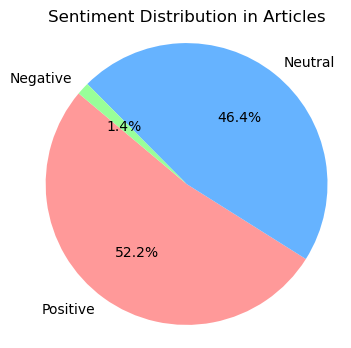

The overall sentiment is Positive.


In [90]:
import pandas as pd
import httpx
import asyncio
from bs4 import BeautifulSoup
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from googlesearch import search
import nest_asyncio
import logging

# Apply necessary asyncio adjustments for Jupyter
nest_asyncio.apply()

# Set up logging for debugging
logging.basicConfig(level=logging.DEBUG)

def perform_google_search(query, max_results=100):
    """Perform a Google search and collect up to max_results URLs, focusing on articles only."""
    results = []
    try:
        # Refine search to exclude video content sites and target articles
        search_query = f"{query} -site:youtube.com -site:vimeo.com"
        for result in search(search_query):
            results.append(result)
            if len(results) >= max_results:
                break
    except Exception as e:
        logging.error("An error occurred while fetching the results: " + str(e))
    return results

async def fetch_article_content(url):
    """Asynchronously fetch content from a URL using httpx with a user-agent."""
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
        async with httpx.AsyncClient(timeout=10.0, follow_redirects=True, headers=headers) as client:
            response = await client.get(url)
            response.raise_for_status()
            return response.text
    except httpx.RequestError as e:
        logging.error(f"Request error for {url}: {str(e)}")
        return None
    except httpx.HTTPStatusError as e:
        logging.error(f"HTTP status error for {url}: {e.response.status_code} - {e.response.reason_phrase}")
        return None

def summarize_text(text, num_sentences=3):
    """Generate a summary of the text using sumy's LSA summarizer."""
    if text is None or text.strip() == "":
        return "No content available"
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, sentences_count=num_sentences)
    return " ".join(str(sentence) for sentence in summary)

async def process_articles(urls):
    """Process a list of URLs to fetch their content and summarize it."""
    contents_summaries = []
    async with httpx.AsyncClient() as client:
        tasks = [fetch_article_content(url) for url in urls]
        responses = await asyncio.gather(*tasks, return_exceptions=True)
        for response in responses:
            if response:  # Handle article content
                soup = BeautifulSoup(response, 'html.parser')
                text = ' '.join(p.get_text(strip=True) for p in soup.find_all('p'))
                if text:
                    summary = summarize_text(text, num_sentences=3)
                    contents_summaries.append((text, summary))
                else:
                    contents_summaries.append(("No content available", "No summary available"))
            else:
                contents_summaries.append(("No content available", "No summary available"))
    return contents_summaries

async def add_content_and_summaries_to_df(query):
    """Main function to manage the workflow from search to DataFrame creation."""
    urls = perform_google_search(query, max_results=100)  # Adjust max_results as needed
    contents_summaries = await process_articles(urls)
    df = pd.DataFrame(contents_summaries, columns=['content', 'summary'])
    df = df[(df['content'] != "No content available") & (df['summary'] != "No summary available") & (df['content'].str.strip() != '') & (df['summary'].str.strip() != '')]
    return df

# User interaction to enter the search query
user_query = input("Please enter your search query: ")

# Run the process and update DataFrame with contents and summaries
df = await add_content_and_summaries_to_df(user_query)

from textblob import TextBlob

def classify_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    # Define simplified thresholds for sentiment
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Apply this function to your DataFrame
df['sentiment'] = df['content'].apply(classify_sentiment)

sentiment_counts = df['sentiment'].value_counts()
sentiment_percentages = sentiment_counts / len(df) * 100  # Convert counts to percentages

import matplotlib.pyplot as plt

# Calculate the counts and percentages of each sentiment category
sentiment_counts = df['sentiment'].value_counts()
sentiment_percentages = sentiment_counts / len(df) * 100

# Plotting the pie chart
plt.figure(figsize=(4, 4))
plt.pie(sentiment_percentages, labels=sentiment_percentages.index, autopct='%1.1f%%', startangle=140, colors=['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700'])
plt.title('Sentiment Distribution in Articles')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Determine the overall sentiment based on the highest percentage
overall_sentiment = sentiment_percentages.idxmax()

# Simplify output to one sentence
print(f"The overall sentiment is {overall_sentiment}.")






## Conclusion

This notebook provided a demonstration of real-time sentiment analysis applied to online articles about eSports and gaming in India. The insights derived from this analysis can be utilized to make informed decisions, improve customer interactions, and adapt strategies in real-time based on public sentiment.
